**DS 301: Applied Data Modeling and Predictive Analysis**

**Lecture 4 – End-to-End Machine Learning Project**

# California Housing Prices Dataset 

Nok Wongpiromsarn, 8 August 2022

**Credit:** The large portion of the code has been taken from Chapter 2 of Aurélien Géron, Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow

## Step 2 Get the Data

**2.1 Load the data using pandas**

In [1]:
import os
import pandas as pd

data_path = os.path.join("datasets", "housing.csv")
data = pd.read_csv(data_path)

**2.2 Take a Quick Look at the Data Structure**

Examine the top 10 rows of the data

In [2]:
data.head(10)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY
5,-122.25,37.85,52.0,919.0,213.0,413.0,193.0,4.0368,269700.0,NEAR BAY
6,-122.25,37.84,52.0,2535.0,489.0,1094.0,514.0,3.6591,299200.0,NEAR BAY
7,-122.25,37.84,52.0,3104.0,687.0,1157.0,647.0,3.1200,241400.0,NEAR BAY
8,-122.26,37.84,42.0,2555.0,665.0,1206.0,595.0,2.0804,226700.0,NEAR BAY
9,-122.25,37.84,52.0,3549.0,707.0,1551.0,714.0,3.6912,261100.0,NEAR BAY


Get a quick description of the data

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


Get counts for categorical attribute

In [4]:
data["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

Get a summary of the numerical attributes

In [5]:
data.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


Plot a histogram

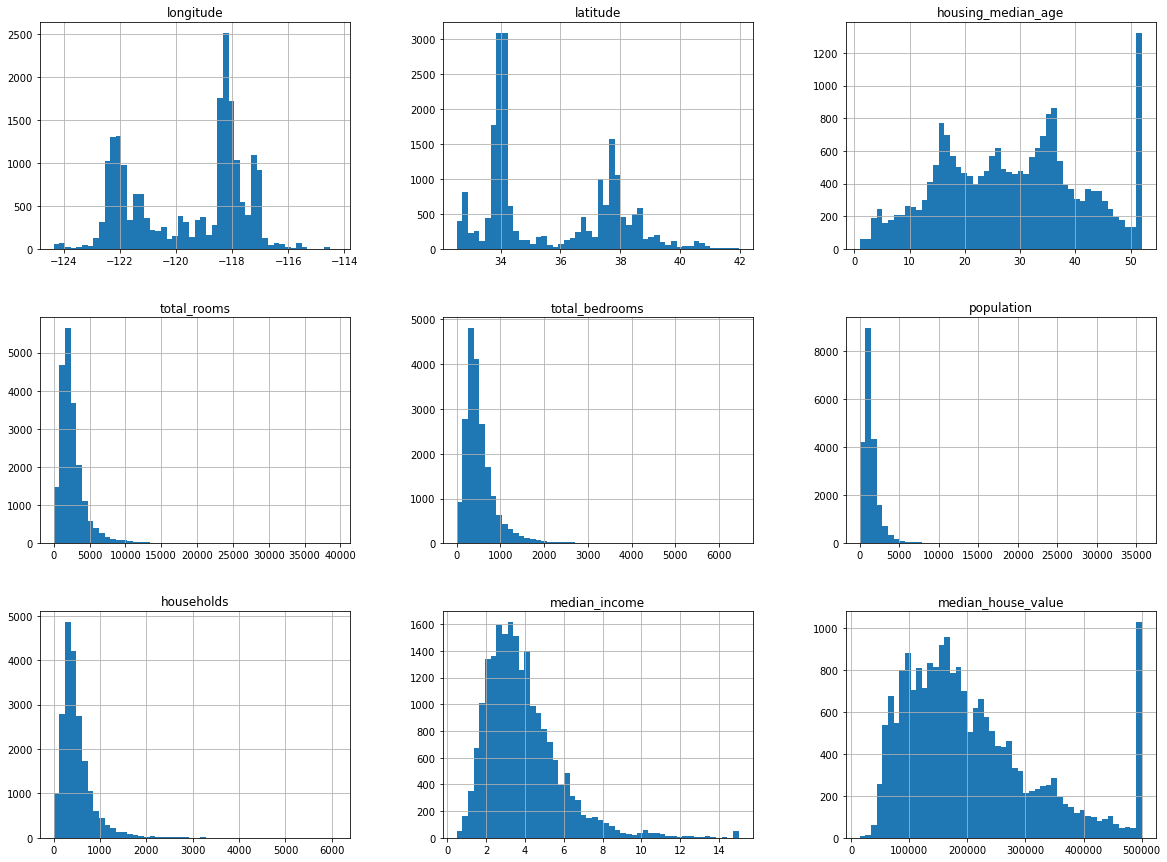

In [6]:
import matplotlib.pyplot as plt
data.hist(bins=50, figsize=(20,15))
plt.show()

**2.3 Create a Test Set**

Split the data into training and test sets

In [7]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(data, test_size=0.2, random_state=42)

Use stratified sampling to ensure that the test set is representative of the various categories of median income

In [8]:
# Create an income category attribute by arranging the median income into bins 
# (0, 1.5], (1.5, 3.0], (3.0, 4.5], (4.5, 6.0] (6.0, inf]
import numpy as np
data["income_cat"] = pd.cut(data["median_income"],
                            bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                            labels=[1, 2, 3, 4, 5])

# Do stratified sampling based on income category
from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(data, data["income_cat"]):
    train_set = data.loc[train_index]
    test_set = data.loc[test_index]

# Remove the income_cat attribute so the data is back to its original state
# Here, axis=1 indicates dropping labels from columns
for s in (train_set, test_set):
    s.drop("income_cat", axis=1, inplace=True)

## Step3: Discover and Visualize the Data to Gain Insights

**3.1 Visualize the geographical data**

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

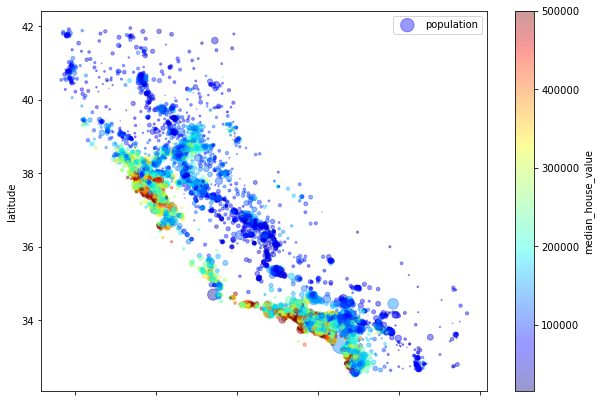

In [9]:
train_set.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
              s=train_set["population"]/100, label="population", figsize=(10,7),
              c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True)

**3.2 Look for correlations**

median_house_value    1.000000
median_income         0.687151
total_rooms           0.135140
housing_median_age    0.114146
households            0.064590
total_bedrooms        0.047781
population           -0.026882
longitude            -0.047466
latitude             -0.142673
Name: median_house_value, dtype: float64


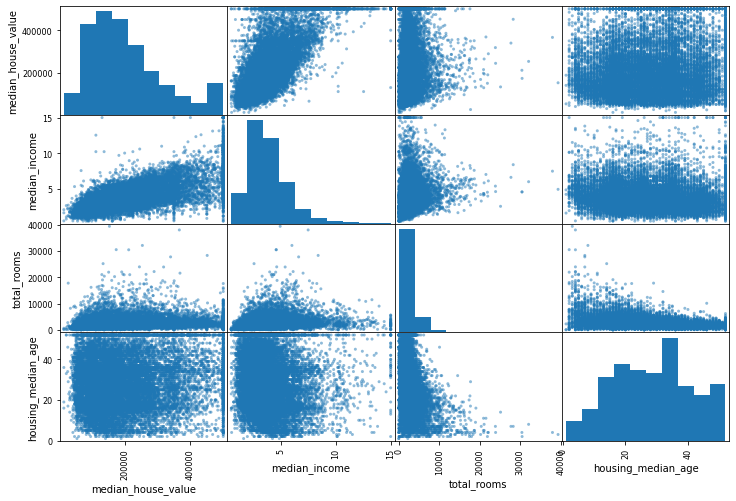

In [10]:
# Compute the correlations
corr_matrix = train_set.corr()
print(corr_matrix["median_house_value"].sort_values(ascending=False))

# Plot pairwise relationships of relevant features.
from pandas.plotting import scatter_matrix

attributes = ["median_house_value",
              "median_income",
              "total_rooms",
              "housing_median_age",
             ]
scatter_matrix(train_set[attributes], figsize=(12,8));

**3.3 Experimenting with Attribute Combinations**

median_house_value    1.000000
median_income         0.687151
total_rooms           0.135140
housing_median_age    0.114146
households            0.064590
total_bedrooms        0.047781
population           -0.026882
longitude            -0.047466
latitude             -0.142673
bedrooms_per_room    -0.259952
Name: median_house_value, dtype: float64


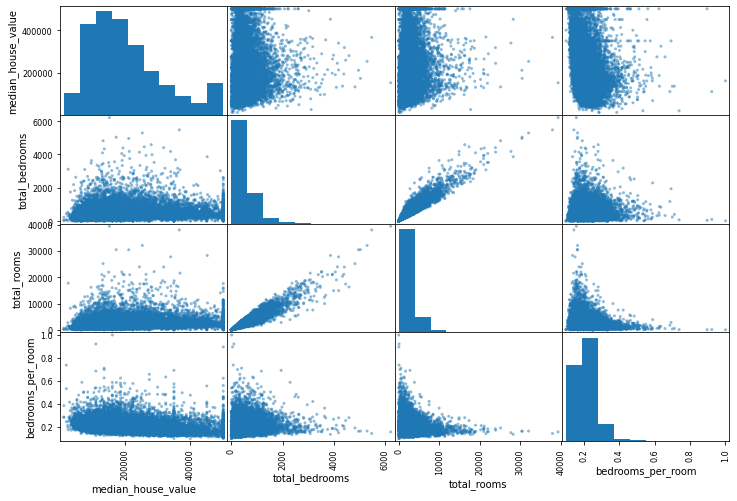

In [11]:
train_set["bedrooms_per_room"] = train_set["total_bedrooms"]/train_set["total_rooms"]

print(train_set.corr()["median_house_value"].sort_values(ascending=False))
attributes = ["median_house_value",
              "total_bedrooms",
              "total_rooms",
              "bedrooms_per_room",
             ]
scatter_matrix(train_set[attributes], figsize=(12,8));

## Step 4: Prepare the Data for Machine Learning Algorithms

**4.1 Data Cleaning**

In [12]:
train_set.info()

# Drop instances with missing features
train_set.drop("bedrooms_per_room", axis=1, inplace=True)
train_set.dropna(subset=["total_bedrooms"], inplace=True)

train_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16512 entries, 12655 to 19773
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           16512 non-null  float64
 1   latitude            16512 non-null  float64
 2   housing_median_age  16512 non-null  float64
 3   total_rooms         16512 non-null  float64
 4   total_bedrooms      16354 non-null  float64
 5   population          16512 non-null  float64
 6   households          16512 non-null  float64
 7   median_income       16512 non-null  float64
 8   median_house_value  16512 non-null  float64
 9   ocean_proximity     16512 non-null  object 
 10  bedrooms_per_room   16354 non-null  float64
dtypes: float64(10), object(1)
memory usage: 1.5+ MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 16354 entries, 12655 to 19773
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              ----------

Separate features and labels

In [13]:
housing_features = train_set.drop("median_house_value", axis=1)
housing_labels = train_set["median_house_value"].copy()

**4.2 Handling Text and Categorical Attributes**

In [14]:
from sklearn.preprocessing import OneHotEncoder

# First, we create the binary vector arrays representation of the ocean_proximity feature with One-Hot Encoding
housing_cat = housing_features[["ocean_proximity"]]
cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat).toarray()

print(cat_encoder.categories_)
print(housing_cat_1hot)

# Construct data frame for one hot encoded columns
housing_cat_1hot_df = pd.DataFrame(housing_cat_1hot, columns=cat_encoder.get_feature_names_out())

# Reset indices to make sure that concat works properly
housing_features.reset_index(drop=True, inplace=True)
housing_cat_1hot_df.reset_index(drop=True, inplace=True)

# Replace the original "ocean_proximity" column with its one hot encoding 
housing_features = pd.concat([housing_features, housing_cat_1hot_df], axis=1).drop(['ocean_proximity'], axis=1)
housing_features.info()

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
      dtype=object)]
[[0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0.]
 ...
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16354 entries, 0 to 16353
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   longitude                   16354 non-null  float64
 1   latitude                    16354 non-null  float64
 2   housing_median_age          16354 non-null  float64
 3   total_rooms                 16354 non-null  float64
 4   total_bedrooms              16354 non-null  float64
 5   population                  16354 non-null  float64
 6   households                  16354 non-null  float64
 7   median_income               16354 non-null  float64
 8   ocean_proximity_<1H OCEAN   16354 non-null  float64
 9   ocean_proximity_INLAND      16354 non-null  float64
 10 

**4.3 Feature Scaling**

In [15]:
from sklearn.preprocessing import StandardScaler

scale_1hot = True

if scale_1hot:
    # Here we apply scaling to all the columns, including one-hot-encoded ones
    scaled_values = StandardScaler().fit_transform(housing_features.values)
    housing_features = pd.DataFrame(scaled_values, index=housing_features.index, columns=housing_features.columns)
else:
    # Only applies scaling to the numerical features
    features = housing_features.columns[:8]
    housing_features[features] = StandardScaler().fit_transform(housing_features[features])

pd.options.display.float_format = "{:.2f}".format
housing_features.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
count,16354.00,16354.00,16354.00,16354.00,16354.00,16354.00,16354.00,16354.00,16354.00,16354.00,16354.00,16354.00,16354.00
mean,0.00,-0.00,0.00,-0.00,0.00,0.00,0.00,0.00,0.00,-0.00,0.00,0.00,0.00
std,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
min,-2.39,-1.45,-2.20,-1.22,-1.29,-1.27,-1.32,-1.77,-0.89,-0.68,-0.01,-0.36,-0.38
25%,-1.11,-0.79,-0.85,-0.55,-0.58,-0.57,-0.58,-0.69,-0.89,-0.68,-0.01,-0.36,-0.38
50%,0.53,-0.65,0.03,-0.24,-0.25,-0.23,-0.24,-0.17,-0.89,-0.68,-0.01,-0.36,-0.38
75%,0.78,0.97,0.66,0.24,0.26,0.27,0.28,0.46,1.13,1.46,-0.01,-0.36,-0.38
max,2.63,2.95,1.86,17.13,13.75,30.71,12.95,5.84,1.13,1.46,90.42,2.82,2.61


## Step 5: Select and Train a Model

**5.1 Training and Evaluating on the Training Set**

In [16]:
# Train a Linear Regression model
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_features, housing_labels)

# Measure the RMSE
from sklearn.metrics import mean_squared_error

predictions = lin_reg.predict(housing_features)
lin_rmse = np.sqrt(mean_squared_error(housing_labels, predictions))
print(lin_rmse)

68986.9197293847


**5.2 K-fold cross-validation**

Split the training set into 10 subsets, train, and evaluate the model 10 times, picking a different subset each time

In [17]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(lin_reg, housing_features, housing_labels, 
                         scoring="neg_mean_squared_error", cv=10)
rmse_scores = np.sqrt(-scores)
np.set_printoptions(formatter={'float_kind':"{:.2f}".format})
print("Scores: {}".format(rmse_scores))
print("Mean: {:.2f}".format(rmse_scores.mean()))
print("standard deviation: {:.2f}".format(rmse_scores.std()))

Scores: [71843.30 65160.85 67468.94 69087.21 66667.24 73328.12 70518.64 69567.99
 66851.52 70808.12]
Mean: 69130.19
standard deviation: 2443.24
